## 1a:

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
import numpy as np
import seaborn as sns

X_train: (60000, 32, 32)
Y_train: (60000,)
X_test:  (10000, 32, 32)
Y_test:  (10000,)


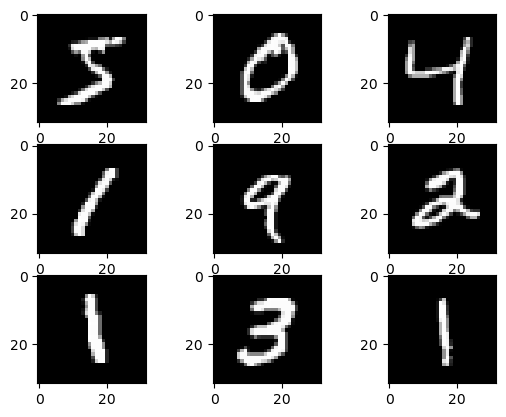

In [2]:
(train_X, train_y), (test_X, test_y) = pickle.load(open("mnist.pkl", "rb"))
 
#shape of dataset
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
 
#plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
for i in range(9):  
    plt.subplot(3,3,i+1)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))


In [25]:
import torch
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(in_channels= 1, out_channels= 6,kernel_size = 5, stride = 1, padding= 0),
                                   nn.Conv2d(in_channels= 6, out_channels= 12,kernel_size = 5, stride = 1, padding= 0)])
        self.fc = nn.ModuleList([nn.Linear(300, 300), nn.Linear(300, 10) ])
        self.bn = [nn.BatchNorm2d(6),nn.BatchNorm2d(12)]
        self.pooling = nn.MaxPool2d(kernel_size = 2)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        for i in range(2):
            x = self.pooling(self.activation(self.bn[i](self.conv[i](x))))
        x = nn.Flatten() (x)
        res2 = x
        y = self.activation(self.fc[0] (x))
        y = y + res2
        y = self.fc[1](y)
        return y  

In [26]:
from torchsummary import summary
model = CNN()
# Input is the (number of channels, image height, image width) if input is 2d, essentially the 2 dimensions of it
s = summary(model, (1,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 6, 28, 28]           156
├─ReLU: 1-1                              [-1, 6, 28, 28]           --
├─MaxPool2d: 1-2                         [-1, 6, 14, 14]           --
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-2                       [-1, 12, 10, 10]          1,812
├─ReLU: 1-3                              [-1, 12, 10, 10]          --
├─MaxPool2d: 1-4                         [-1, 12, 5, 5]            --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-3                       [-1, 300]                 90,300
├─ReLU: 1-5                              [-1, 300]                 --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-4                       [-1, 10]                  3,010
Tota

In [15]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [16]:
from torch.optim import SGD, Adam
import torch
from torch import nn
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, 
                 input_transform=lambda x: x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False, tens_logger = None):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_inputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        # Conversion of input arrays to correct shape
        train_input = self.input_transform(inputs)
        val_inputs = self.input_transform(val_inputs)
        
        # Conversion of arrays to tensors
        inputs = torch.tensor(train_input, dtype= torch.float)
        outputs = torch.tensor(outputs, dtype = torch.int64)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    # Square and sum each entry in each of the arrays and then sum all outputs from all arrays
                    loss = loss + 1e-5 * sum([(wei ** 2).sum() for wei in self.model.parameters()])
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.detach().item() * batch_importance
                acc = sum(torch.argmax(batch_predictions, dim = 1) == batch_output) / len(batch_output)
                epoch_acc += acc.detach().item() * batch_importance
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            if tens_logger is not None:
                tens_logger.add_scalar("losses", epoch_loss, n_epoch + 1)
                tens_logger.add_scalar("accuracies", epoch_acc, n_epoch + 1)
                tens_logger.add_scalar("val_losses", val_loss, n_epoch + 1)
                tens_logger.add_scalar("val_accuracies", val_acc, n_epoch + 1)
        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies,
               "model": self.model}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        tensor_inp = torch.tensor(inputs, dtype = torch.float)
        tensor_out = torch.tensor(outputs, dtype = torch.int64)
        
        preds = self.model(tensor_inp)
        losses = nn.CrossEntropyLoss()(preds, tensor_out)
        losses = losses.item()
        acc = (sum(torch.argmax(preds, axis= 1) == tensor_out) / len(tensor_out)).item()
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

The fact that I am getting comparable accuracy with 20 * 128 reduction in number of epochs is insane, time per epoch has increased tho to 5 seconds so takes 5 seconds to run through all the batches in train dataset

In [17]:
# Conversion of test dataset to right shape
temp = lambda x: x.reshape(x.shape[0], 1 , x.shape[1], x.shape[2])
reshaped_test_x = temp(test_X)
reshaped_test_x.shape

(10000, 1, 32, 32)

In [18]:
from torch.utils.tensorboard import SummaryWriter
cnn_logger = SummaryWriter(log_dir = 'CNN_MNIST')
cnn_logger.flush()

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.33, random_state=42)

In [23]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(40200, 32, 32)
(19800, 32, 32)
(40200,)
(19800,)


## Running Model With Both Batch Normalization & Skip Connection

In [27]:
cnn = CNN()
mlp_trainer = Trainer(cnn, 'adam', 1e-3, 30, 128)
train_val_dict = mlp_trainer.train(X_train, y_train, X_val,y_val, early_stop= True, l2= True, tens_logger= cnn_logger)
test_acc = mlp_trainer.evaluate(reshaped_test_x, test_y, print_acc= False)[1]
print("Test Accuracy:", test_acc)

  3%|█▍                                          | 1/30 [00:12<05:48, 12.03s/it]

Epoch 1/30 - Loss: 0.278 - Acc: 0.922
              Val_loss: 0.105 - Val_acc: 0.970


 37%|███████████████▊                           | 11/30 [02:14<03:53, 12.30s/it]

Epoch 11/30 - Loss: 0.020 - Acc: 0.995
              Val_loss: 0.039 - Val_acc: 0.988


 70%|██████████████████████████████             | 21/30 [04:18<01:52, 12.46s/it]

Epoch 21/30 - Loss: 0.009 - Acc: 0.999
              Val_loss: 0.043 - Val_acc: 0.990


func:'train'  took: 371.2909 sec
Test Accuracy: 0.9909999966621399


## Running Model Without Batch Normalization But Have Skip Connection

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(in_channels= 1, out_channels= 6,kernel_size = 5, stride = 1, padding= 0),
                                   nn.Conv2d(in_channels= 6, out_channels= 12,kernel_size = 5, stride = 1, padding= 0)])
        self.fc = nn.ModuleList([nn.Linear(300, 300), nn.Linear(300, 10) ])
        #self.bn = [nn.BatchNorm2d(6),nn.BatchNorm2d(12)]
        self.pooling = nn.MaxPool2d(kernel_size = 2)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        for i in range(2):
            x = self.pooling(self.activation((self.conv[i](x))))
        x = nn.Flatten() (x)
        res2 = x
        y = self.activation(self.fc[0] (x))
        y = y + res2
        y = self.fc[1](y)
        return y  

In [29]:
model = CNN()
# Input is the (number of channels, image height, image width) if input is 2d, essentially the 2 dimensions of it
s = summary(model, (1,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 6, 28, 28]           156
├─ReLU: 1-1                              [-1, 6, 28, 28]           --
├─MaxPool2d: 1-2                         [-1, 6, 14, 14]           --
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-2                       [-1, 12, 10, 10]          1,812
├─ReLU: 1-3                              [-1, 12, 10, 10]          --
├─MaxPool2d: 1-4                         [-1, 12, 5, 5]            --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-3                       [-1, 300]                 90,300
├─ReLU: 1-5                              [-1, 300]                 --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-4                       [-1, 10]                  3,010
Tota

In [30]:
cnn = CNN()
mlp_trainer = Trainer(cnn, 'adam', 1e-3, 30, 128)
train_val_dict = mlp_trainer.train(X_train, y_train, X_val,y_val, early_stop= True, l2= True, tens_logger= cnn_logger)
test_acc = mlp_trainer.evaluate(reshaped_test_x, test_y, print_acc= False)[1]
print("Test Accuracy:", test_acc)

  3%|█▍                                          | 1/30 [00:10<05:17, 10.94s/it]

Epoch 1/30 - Loss: 1.372 - Acc: 0.848
              Val_loss: 0.174 - Val_acc: 0.953


 37%|███████████████▊                           | 11/30 [02:04<03:36, 11.40s/it]

Epoch 11/30 - Loss: 0.026 - Acc: 0.992
              Val_loss: 0.102 - Val_acc: 0.977


 70%|██████████████████████████████             | 21/30 [03:57<01:41, 11.30s/it]

Epoch 21/30 - Loss: 0.018 - Acc: 0.995
              Val_loss: 0.105 - Val_acc: 0.981


func:'train'  took: 338.3172 sec
Test Accuracy: 0.9855999946594238


### Getting better test accuracy when running the model with Batch Normalization

## Q1B: Running Model with Batch Norm but NO skip connection at 10 epochs & LR of 5e-3

In [31]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(in_channels= 1, out_channels= 6,kernel_size = 5, stride = 1, padding= 0),
                                   nn.Conv2d(in_channels= 6, out_channels= 12,kernel_size = 5, stride = 1, padding= 0)])
        self.fc = nn.ModuleList([nn.Linear(300, 300), nn.Linear(300, 10) ])
        self.bn = [nn.BatchNorm2d(6),nn.BatchNorm2d(12)]
        self.pooling = nn.MaxPool2d(kernel_size = 2)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        for i in range(2):
            x = self.pooling(self.activation(self.bn[i](self.conv[i](x))))
        x = nn.Flatten() (x)
        x = self.activation(self.fc[0] (x))
        x = self.fc[1](x)
        return x  

In [32]:
model = CNN()
# Input is the (number of channels, image height, image width) if input is 2d, essentially the 2 dimensions of it
s = summary(model, (1,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 6, 28, 28]           156
├─ReLU: 1-1                              [-1, 6, 28, 28]           --
├─MaxPool2d: 1-2                         [-1, 6, 14, 14]           --
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-2                       [-1, 12, 10, 10]          1,812
├─ReLU: 1-3                              [-1, 12, 10, 10]          --
├─MaxPool2d: 1-4                         [-1, 12, 5, 5]            --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-3                       [-1, 300]                 90,300
├─ReLU: 1-5                              [-1, 300]                 --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-4                       [-1, 10]                  3,010
Tota

In [33]:
cnn = CNN()
mlp_trainer = Trainer(cnn, 'adam', 5e-3, 10, 128)
train_val_dict = mlp_trainer.train(X_train, y_train, X_val,y_val, early_stop= True, l2= True, tens_logger= cnn_logger)
test_acc = mlp_trainer.evaluate(reshaped_test_x, test_y, print_acc= False)[1]
print("Test Accuracy:", test_acc)

 10%|████▍                                       | 1/10 [00:12<01:51, 12.42s/it]

Epoch 1/10 - Loss: 0.179 - Acc: 0.945
              Val_loss: 0.091 - Val_acc: 0.971


func:'train'  took: 130.5418 sec
Test Accuracy: 0.9864000082015991


## Running the Model with Both Skip Connection & Batch Norm at 10 epochs and LR of 5e-3

In [34]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(in_channels= 1, out_channels= 6,kernel_size = 5, stride = 1, padding= 0),
                                   nn.Conv2d(in_channels= 6, out_channels= 12,kernel_size = 5, stride = 1, padding= 0)])
        self.fc = nn.ModuleList([nn.Linear(300, 300), nn.Linear(300, 10) ])
        self.bn = [nn.BatchNorm2d(6),nn.BatchNorm2d(12)]
        self.pooling = nn.MaxPool2d(kernel_size = 2)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        for i in range(2):
            x = self.pooling(self.activation(self.bn[i](self.conv[i](x))))
        x = nn.Flatten() (x)
        res2 = x
        y = self.activation(self.fc[0] (x))
        y = y + res2
        y = self.fc[1](y)
        return y  

In [35]:
model = CNN()
# Input is the (number of channels, image height, image width) if input is 2d, essentially the 2 dimensions of it
s = summary(model, (1,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 6, 28, 28]           156
├─ReLU: 1-1                              [-1, 6, 28, 28]           --
├─MaxPool2d: 1-2                         [-1, 6, 14, 14]           --
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-2                       [-1, 12, 10, 10]          1,812
├─ReLU: 1-3                              [-1, 12, 10, 10]          --
├─MaxPool2d: 1-4                         [-1, 12, 5, 5]            --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-3                       [-1, 300]                 90,300
├─ReLU: 1-5                              [-1, 300]                 --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-4                       [-1, 10]                  3,010
Tota

In [36]:
cnn = CNN()
mlp_trainer = Trainer(cnn, 'adam', 5e-3, 10, 128)
train_val_dict = mlp_trainer.train(X_train, y_train, X_val,y_val, early_stop= True, l2= True, tens_logger= cnn_logger)
test_acc = mlp_trainer.evaluate(reshaped_test_x, test_y, print_acc= False)[1]
print("Test Accuracy:", test_acc)

 10%|████▍                                       | 1/10 [00:12<01:52, 12.54s/it]

Epoch 1/10 - Loss: 0.183 - Acc: 0.946
              Val_loss: 0.062 - Val_acc: 0.980


func:'train'  took: 130.5511 sec
Test Accuracy: 0.9879999756813049


### Getting slightly better test accuracy with the skip connection, and around the same training time for both versions of this model (without and with skip connection for 10 epochs and LR of 5e-3)